# Q3: Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

Notebook to analyse correlations of nuclear energy usage with economic and political indicators.

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter
cc = country_converter.CountryConverter()

from clean_data_after_merge import clean_data_after_merge
import plot_geopandas_interactive_map

### Loading, Selection and Cleaning of Data

In [2]:
data = pd.read_csv('../data/data_merged/data.csv')
data = clean_data_after_merge(data).set_index(['year','country']).sort_index()
data = data[
    [# economy
     'population','GDP','GDP growth', 'GDP per capita', 'GDP per capita growth',
     'income per capita', 'income per capita growth', 
     # political 
     'research_%GDP','representative_government', 'fundamental_rights',
     'checks_on_gouvernment', 'impartial_administration','civil_society_participation',
     'nuclear_warheads','accident_cost_MioUSD2013', 'accident_deaths',
     # nuclear energy 
     'built_reactors', 'shutdown_reactors', 'operating_reactors',
     'cons_btu','nuclear_cons_btu', 'prod_btu', 'nuclear_prod_btu']
]

In [3]:
# function for cleaning, filtering and interpoation of missing values
def clean_data(data):
    data_cleaned = data.copy()
    
    # drop countries with many NaNs (more than 300 total)
    nans = data_cleaned.isna().sum(axis=1).sum(axis=0,level='country')
    countries = nans[nans<300].index 
    excluded = nans[nans>=300].index
    print('Excluded countries: ', cc.convert(excluded.to_list(), src='ISO3', to='short'))
    data_cleaned = data_cleaned.query('country in @countries')
    
    # fill production of nuclear energy with 0, if 'operating_reactors'==0 and 'nuclear_prod_btu'==NaN
    for year,country in data_cleaned.index:
        if (not data_cleaned['operating_reactors'].at[year,country].astype('bool')) and data['nuclear_prod_btu'].isna().at[year,country]:
            data_cleaned['nuclear_prod_btu'].at[year,country] = 0
    
    
    # interpolate per feature and country
    for column in data_cleaned.columns:
        if column in ['accident_cost_MioUSD2013','accident_deaths']: 
            data_cleaned[column] = data_cleaned[column].replace('No Accident',0)
        data_cleaned[column] = data_cleaned[column].unstack().interpolate().stack()
    
    return data_cleaned

data_cleaned = clean_data(data)

# print shapes and NAN-count
print('\nDATA: \t',data.shape, data.isna().sum().sum(),
      '\nCLEANED:', data_cleaned.shape, data_cleaned.isna().sum().sum())

Excluded countries:  ['Curacao', 'Djibouti', 'Eritrea', 'Guadeloupe', 'Maldives', 'Montenegro', 'Martinique', 'New Caledonia', 'Palestine', 'French Polynesia', 'South Sudan', 'Timor-Leste']


<ipython-input-3-57376d0ea821>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].unstack().interpolate().stack()



DATA: 	 (7176, 23) 21852 
CLEANED: (6708, 23) 14798


<ipython-input-3-57376d0ea821>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].replace('No Accident',0)


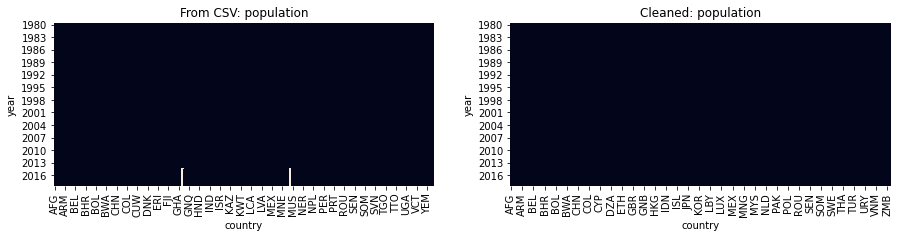

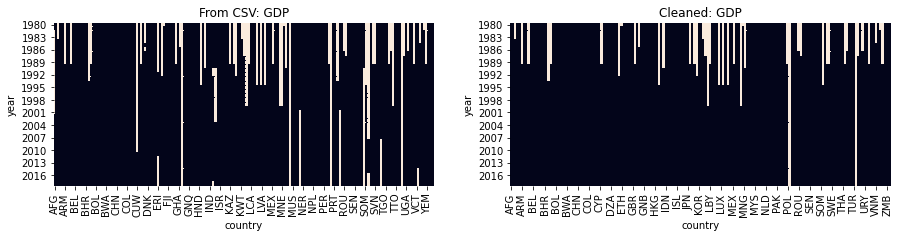

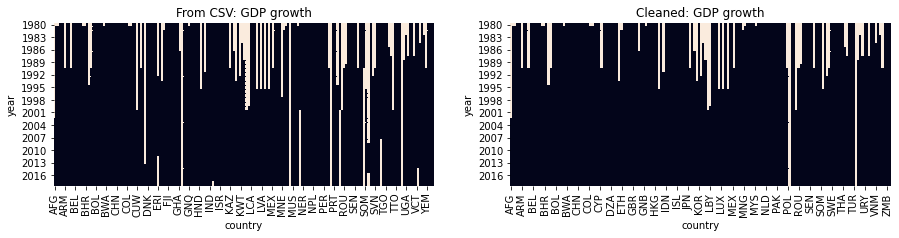

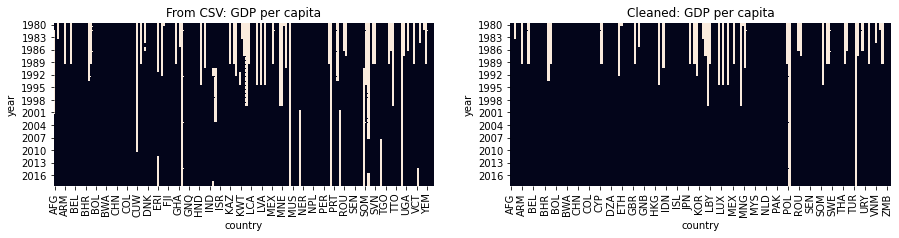

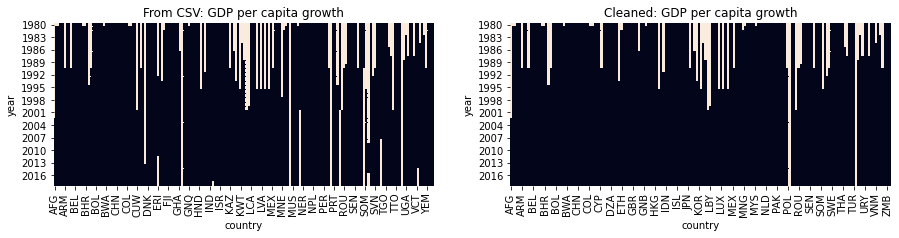

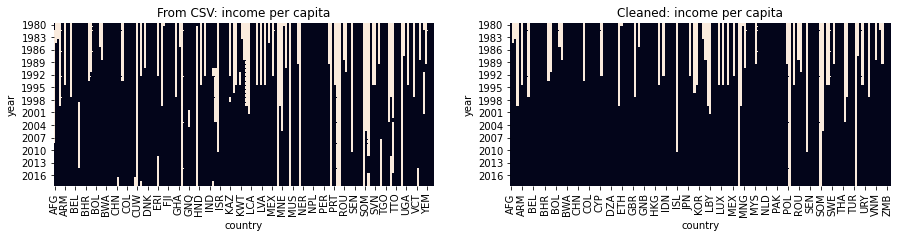

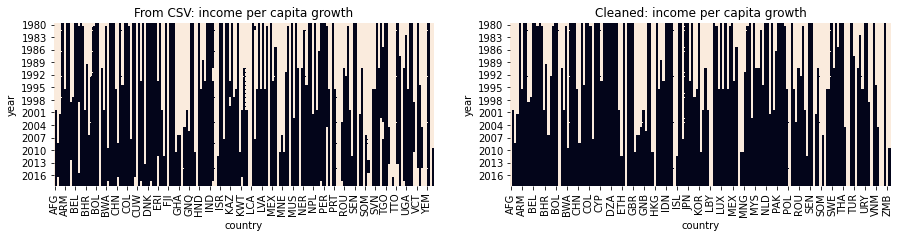

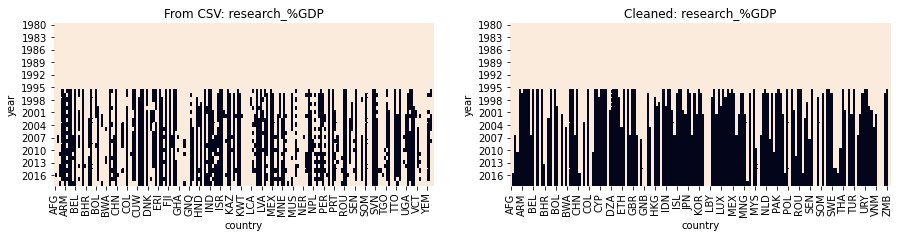

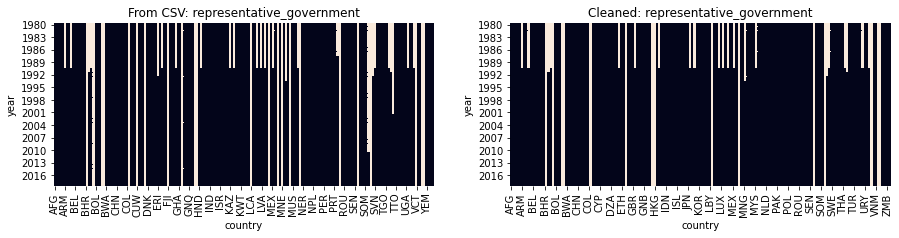

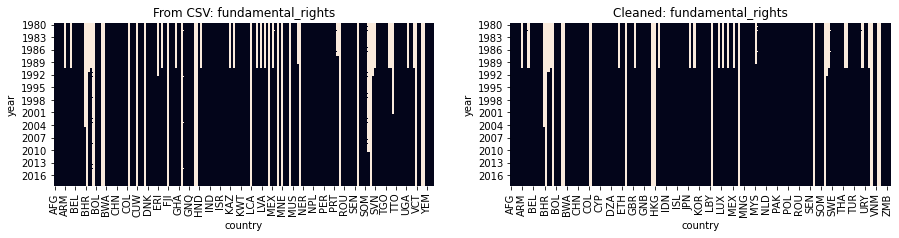

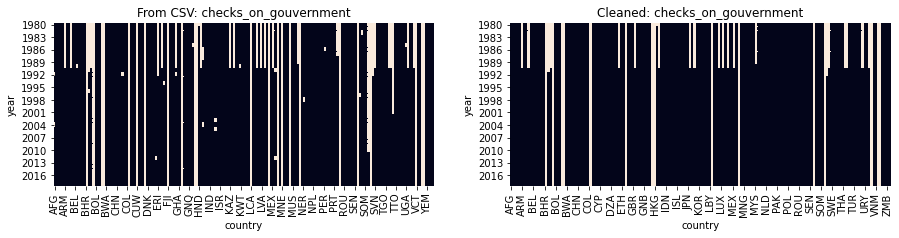

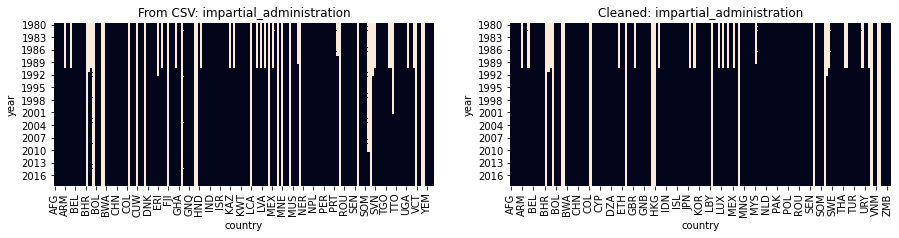

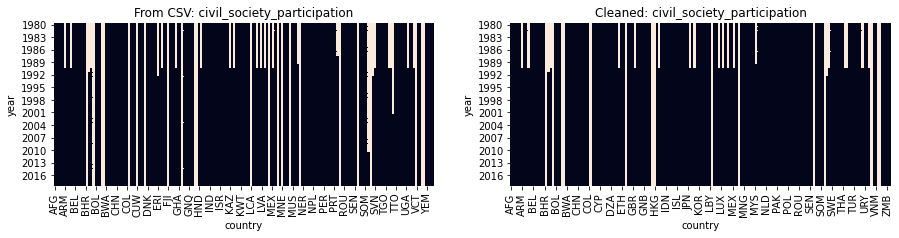

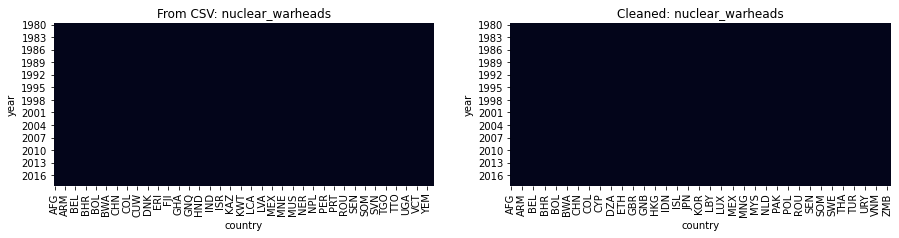

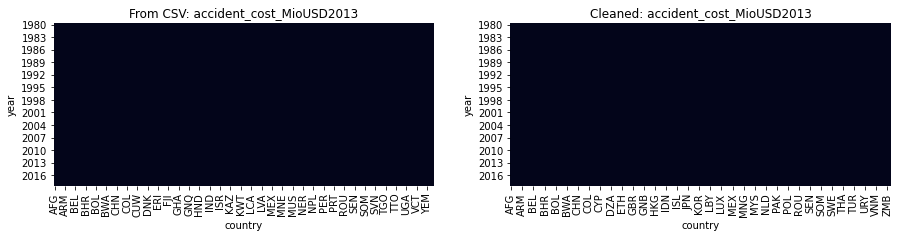

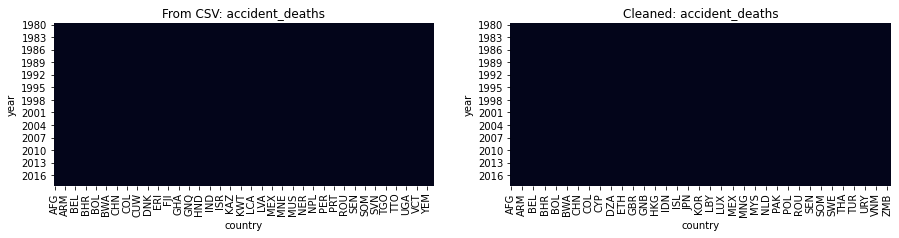

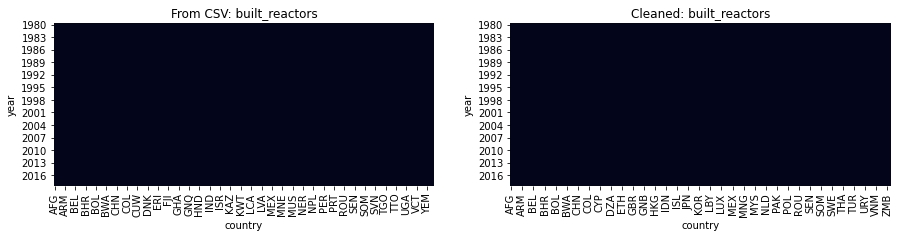

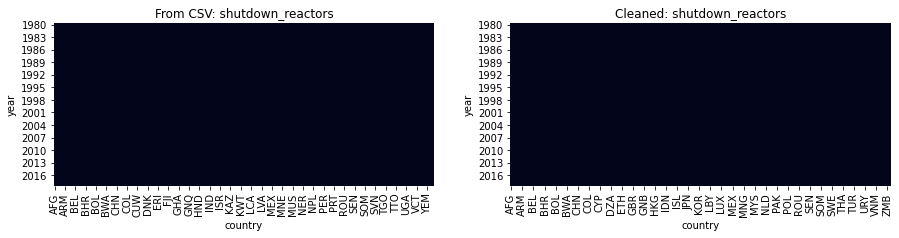

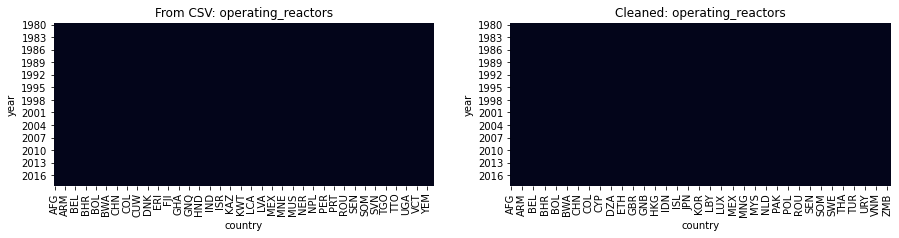

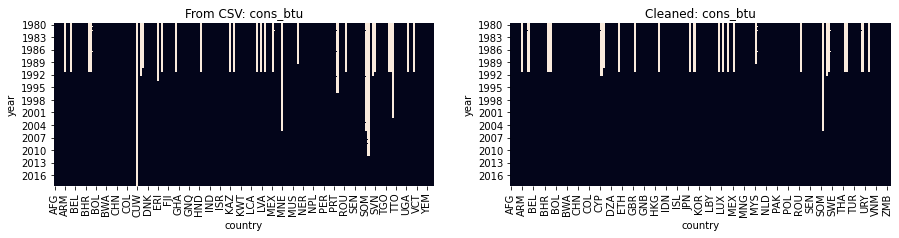

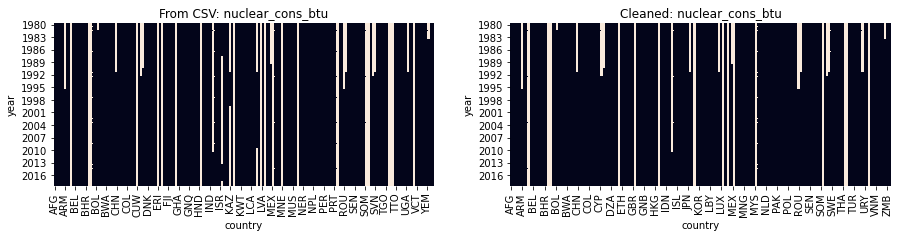

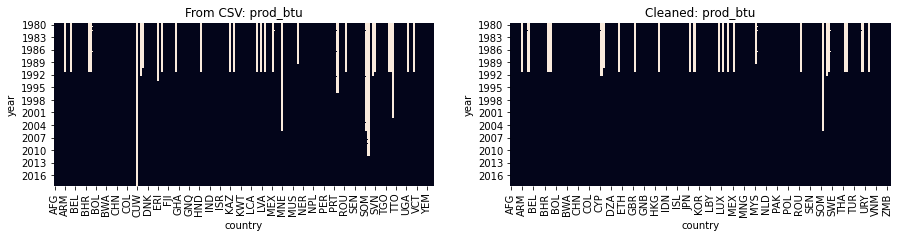

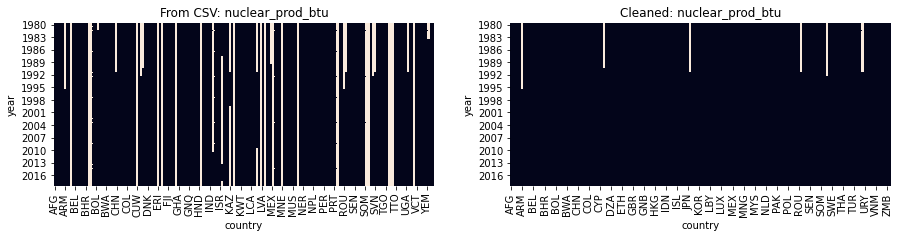

In [4]:
# heatmaps of missing data compared for initial and cleand data
for i,column in enumerate(data.columns):
    plt.figure(figsize=[15,3])
    plt.subplot(121)
    sns.heatmap(data[column].unstack().isna(), vmin=0, vmax=1, cbar=False)
    plt.title('From CSV: ' + column)
    plt.subplot(122)
    sns.heatmap(data_cleaned[column].unstack().isna(), vmin=0, vmax=1, cbar=False)
    plt.title('Cleaned: ' + data_cleaned.columns[i])
    plt.show()

In [5]:
# total missing values per column
pd.concat([data.isna().sum().rename('NaNs in CSV'), data_cleaned.isna().sum().rename('NaNs in Cleaned data')], axis=1)

NaNs in CSV  NaNs in Cleaned data
population                             8                     0
GDP                                  807                   473
GDP growth                           882                   547
GDP per capita                       810                   473
GDP per capita growth                885                   550
income per capita                   1345                   837
income per capita growth            2788                  2231
research_%GDP                       5269                  4159
representative_government           1209                   823
fundamental_rights                  1218                   832
checks_on_gouvernment               1217                   808
impartial_administration            1193                   807
civil_society_participation         1193                   807
nuclear_warheads                       0                     0
accident_cost_MioUSD2013               0                     0
accident_deaths                        0                     0
built_reactors                         0                     0
shutdown_reactors                      0                     0
operating_reactors                     0                     0
cons_btu                             452                   301
nuclear_cons_btu                    1062                   773
prod_btu                             452                   301
nuclear_prod_btu                    1062                    76

### Calculate and Select Features

In [7]:
data_amount = data_cleaned[[
    'GDP per capita', 'income per capita', 'representative_government', 'fundamental_rights',
    'checks_on_gouvernment', 'impartial_administration','civil_society_participation', 'nuclear_warheads',
    'accident_cost_MioUSD2013', 'accident_deaths', 'built_reactors','shutdown_reactors', 'operating_reactors']]
data_amount.insert(2, 'research_%GDP_per_capita', data_cleaned['research_%GDP'])
data_amount['nuclear_cons_btu'] = data_cleaned['nuclear_cons_btu']
data_amount['nuclear_cons_share'] = data_cleaned['nuclear_cons_btu'].divide(data_cleaned['cons_btu'])
data_amount['nuclear_prod_btu'] = data_cleaned['nuclear_cons_btu']
data_amount['nuclear_prod_share'] = data_cleaned['nuclear_prod_btu'].divide(data_cleaned['prod_btu'])

<ipython-input-7-76584b8d0c1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amount['nuclear_cons_btu'] = data_cleaned['nuclear_cons_btu']
<ipython-input-7-76584b8d0c1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amount['nuclear_cons_share'] = data_cleaned['nuclear_cons_btu'].divide(data_cleaned['cons_btu'])
<ipython-input-7-76584b8d0c1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [8]:
data_growth = pd.DataFrame()
data_growth['GDP per capita growth'] = data_cleaned['GDP per capita growth']
data_growth['income per capita growth'] = data_cleaned['income per capita'].unstack().pct_change().stack()
data_growth['research_%GDP_per_capita_growth'] = data_amount['research_%GDP_per_capita'].unstack().pct_change().stack()
for column in ['representative_government', 'fundamental_rights', 'checks_on_gouvernment', 
               'impartial_administration','civil_society_participation', 'nuclear_warheads',
               'nuclear_warheads', 'built_reactors','shutdown_reactors', 'operating_reactors']:
    data_growth[column+'_growth'] = data_cleaned[column].unstack().pct_change().stack()
data_growth['accident_cost_MioUSD2013'] = data_cleaned['accident_cost_MioUSD2013']
data_growth['accident_deaths'] = data_cleaned['accident_deaths']
data_growth['nuclear_cons_btu_growth'] = data_amount['nuclear_cons_btu'].unstack().pct_change().stack()
data_growth['nuclear_cons_share_growth'] = data_amount['nuclear_cons_share'].unstack().diff().stack()
data_growth['nuclear_prod_btu_growth'] = data_amount['nuclear_prod_btu'].unstack().pct_change().stack()
data_growth['nuclear_prod_share_growth'] = data_amount['nuclear_prod_share'].unstack().diff().stack()

In [9]:
display(data_amount.isna().sum().sort_values())
display(data_growth.isna().sum().sort_values())

nuclear_warheads                  0
operating_reactors                0
shutdown_reactors                 0
built_reactors                    0
accident_deaths                   0
accident_cost_MioUSD2013          0
GDP per capita                  473
nuclear_prod_share              748
nuclear_prod_btu                773
nuclear_cons_btu                773
nuclear_cons_share              773
civil_society_participation     807
impartial_administration        807
checks_on_gouvernment           808
representative_government       823
fundamental_rights              832
income per capita               837
research_%GDP_per_capita       4159
dtype: int64

accident_deaths                          0
accident_cost_MioUSD2013                 0
GDP per capita growth                  550
nuclear_prod_share_growth              922
nuclear_cons_share_growth              930
impartial_administration_growth        964
checks_on_gouvernment_growth           965
civil_society_participation_growth     969
fundamental_rights_growth              989
income per capita growth              1005
representative_government_growth      1535
research_%GDP_per_capita_growth       4297
built_reactors_growth                 5490
operating_reactors_growth             5546
nuclear_prod_btu_growth               5609
nuclear_cons_btu_growth               5609
shutdown_reactors_growth              6092
nuclear_warheads_growth               6450
dtype: int64

## Visualisation

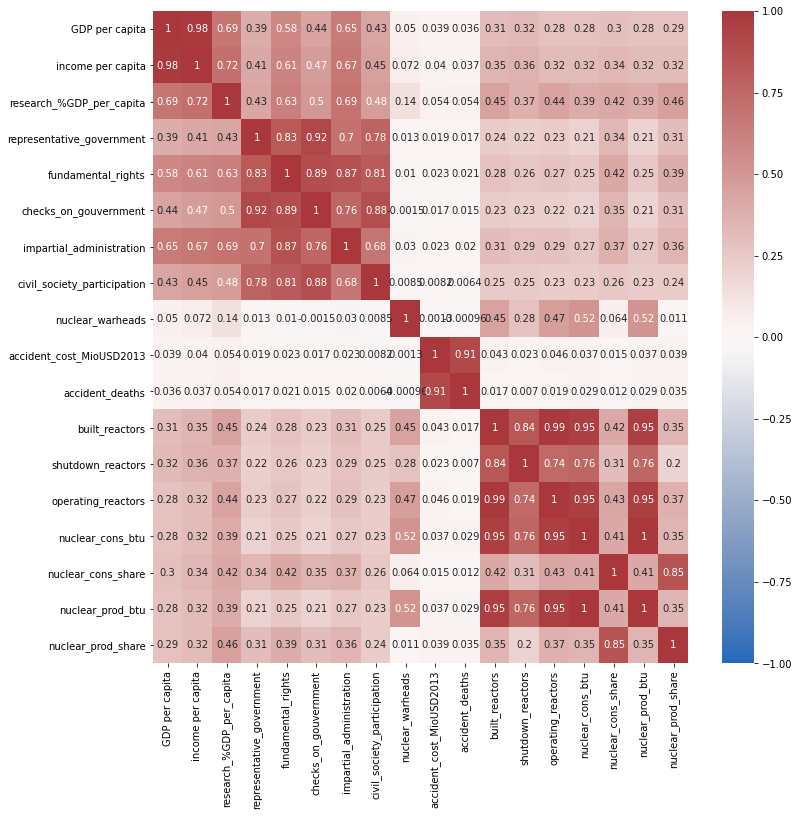

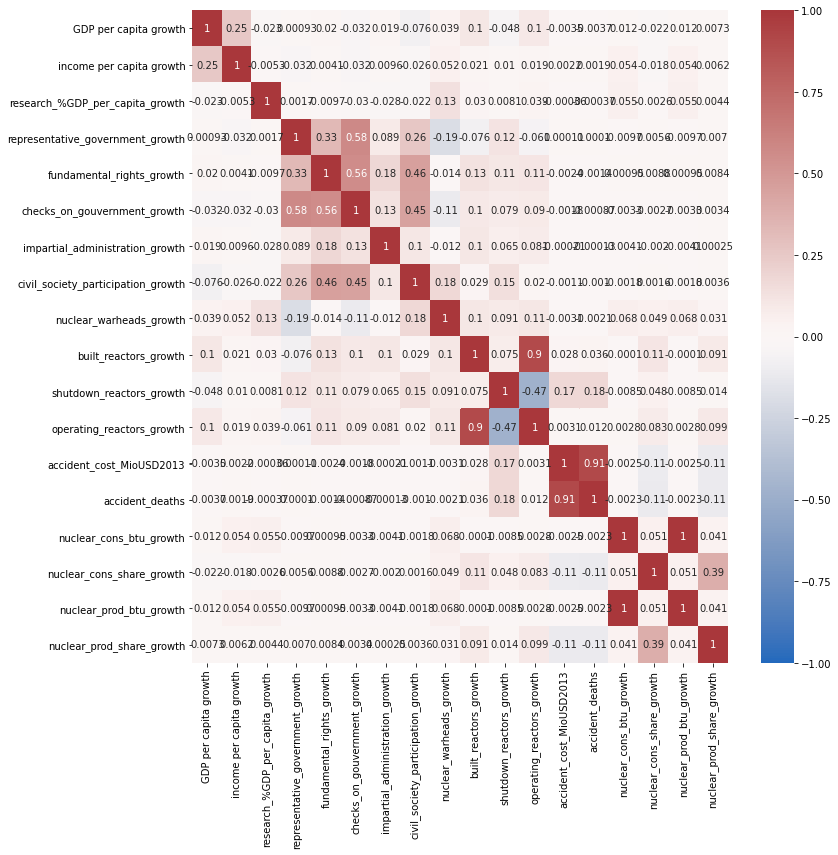

In [10]:
plt.figure(figsize=[12,12])
sns.heatmap(data_amount.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.show()
plt.figure(figsize=[12,12])
sns.heatmap(data_growth.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.show()

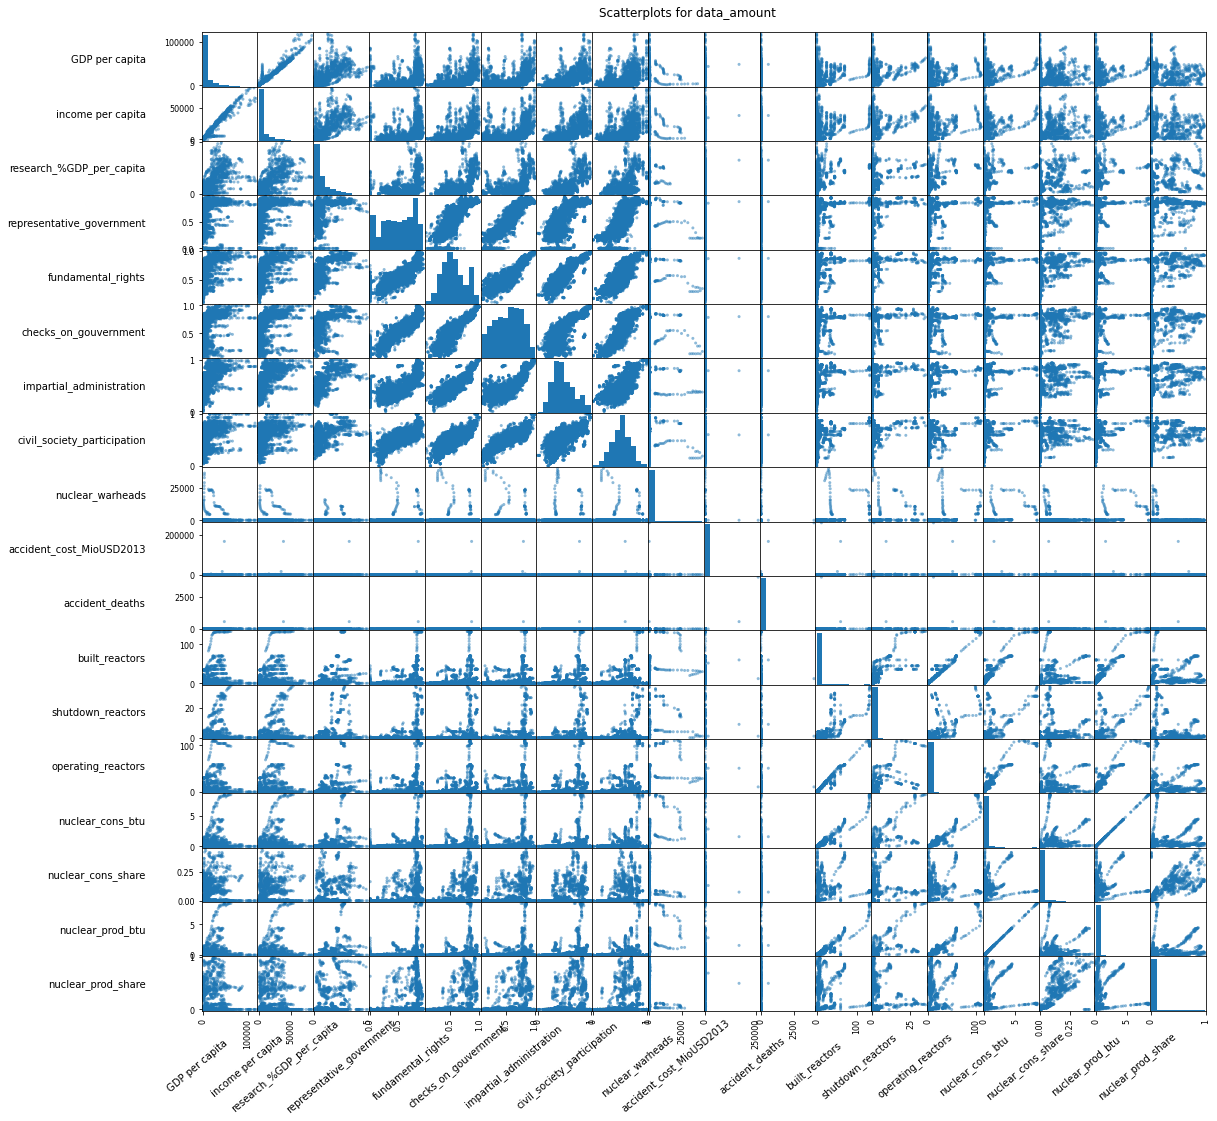

In [11]:
sm = pd.plotting.scatter_matrix(data_amount, figsize=(18, 18), diagonal='hist')
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(40)
    s.yaxis.label.set_rotation(0)
    s.xaxis.label.set_horizontalalignment('right')
    s.yaxis.label.set_horizontalalignment('right')
    s.xaxis.label.set_verticalalignment('center')
    s.yaxis.label.set_verticalalignment('center')
    s.get_yaxis().set_label_coords(-1,0.5)
    s.get_xaxis().set_label_coords(0.5,-1)
plt.suptitle('Scatterplots for data_amount', position=(0.5,0.9))
plt.show()

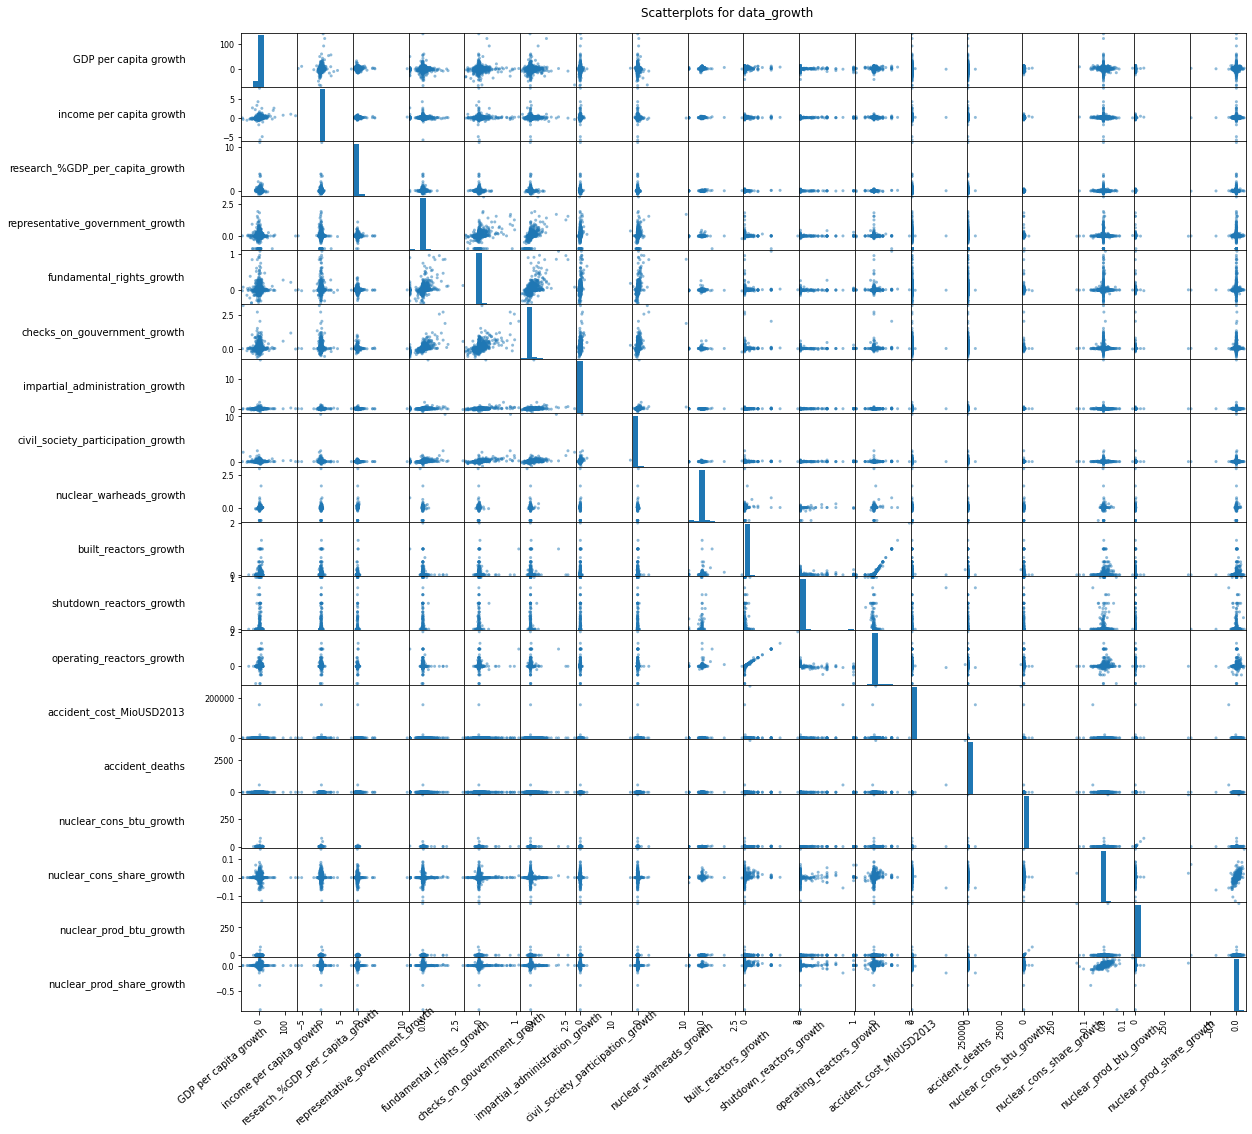

In [12]:
sm = pd.plotting.scatter_matrix(data_growth.replace({np.inf:np.nan}), figsize=(18, 18), diagonal='hist')
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(40)
    s.yaxis.label.set_rotation(0)
    s.xaxis.label.set_horizontalalignment('right')
    s.yaxis.label.set_horizontalalignment('right')
    s.xaxis.label.set_verticalalignment('center')
    s.yaxis.label.set_verticalalignment('center')
    s.get_yaxis().set_label_coords(-1,0.5)
    s.get_xaxis().set_label_coords(0.5,-1)
plt.suptitle('Scatterplots for data_growth', position=(0.5,0.9))
plt.show()

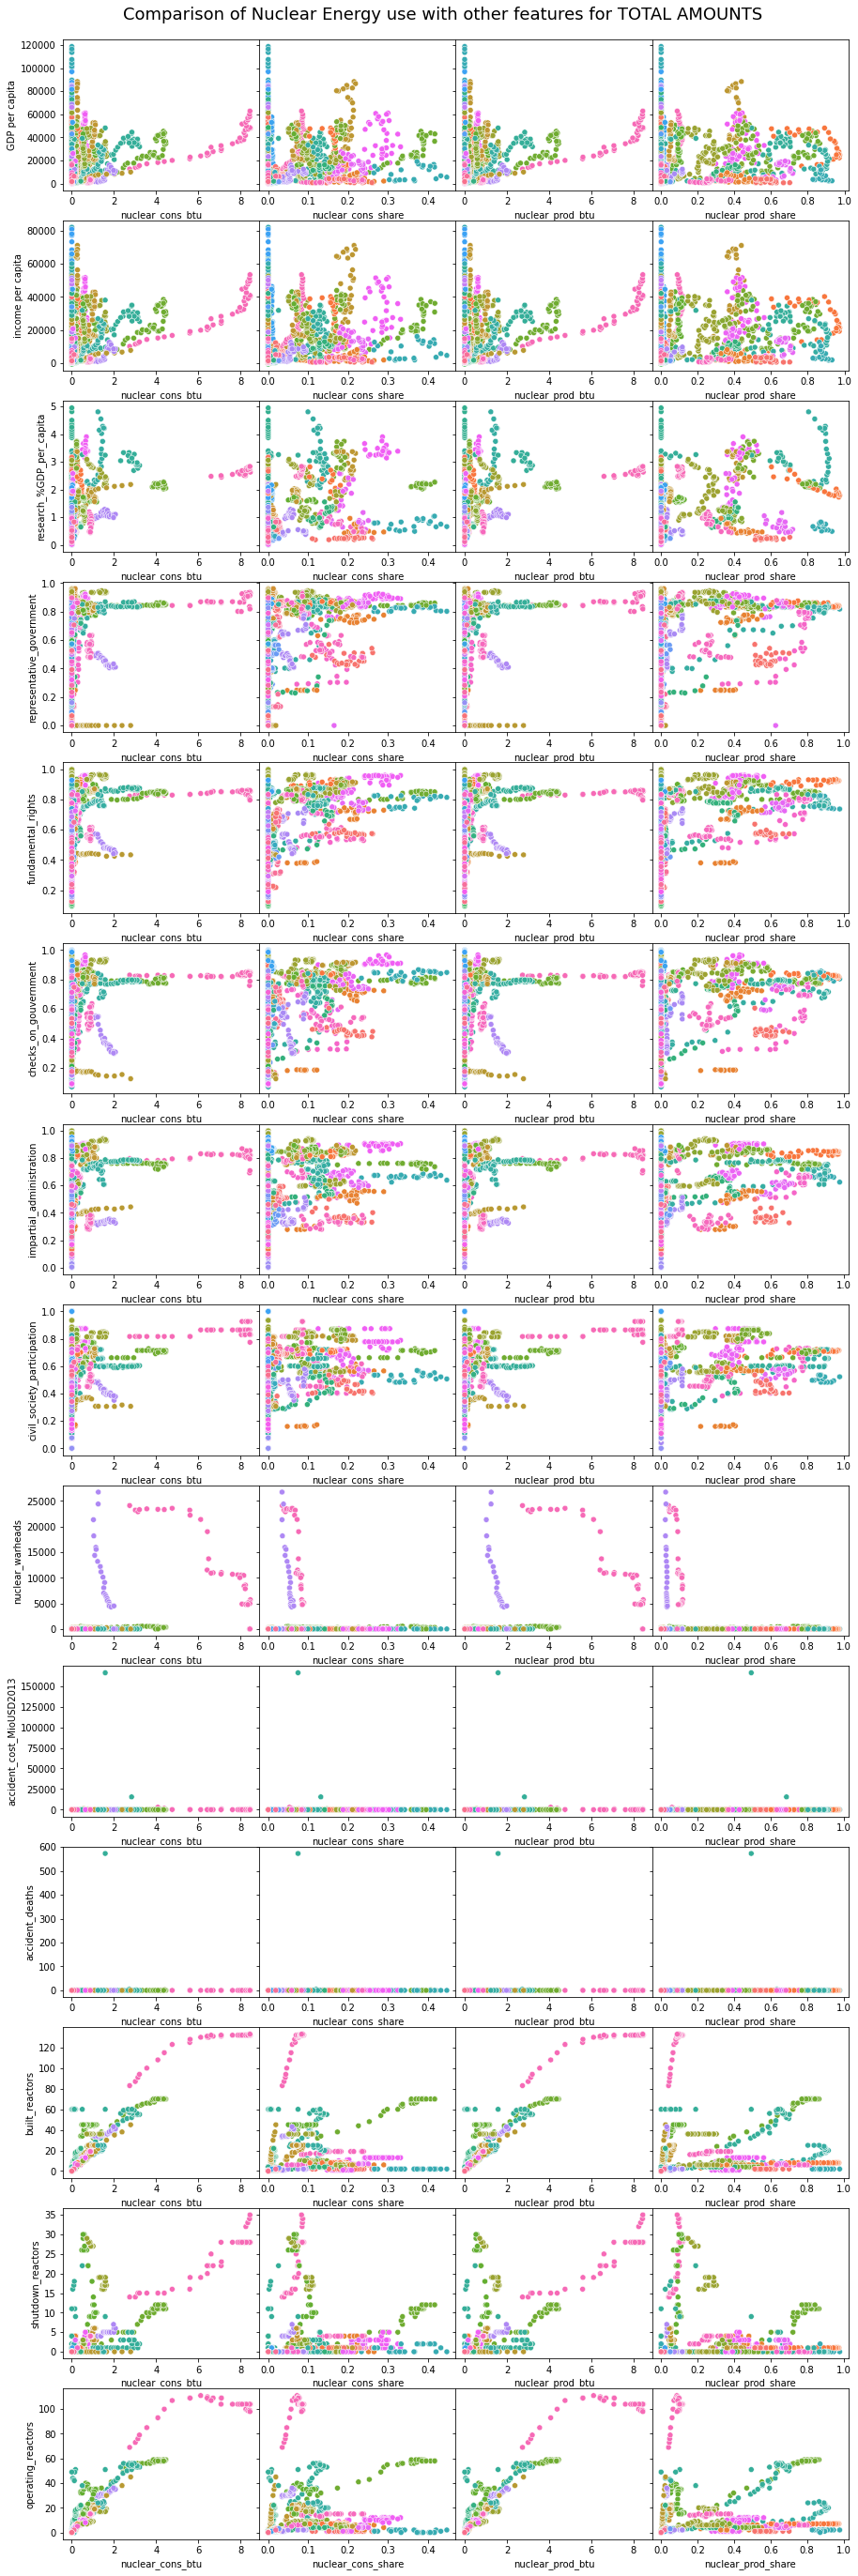

In [13]:
fig,ax = plt.subplots(len(data_amount.columns)-4,4, figsize=[15,3.5*(len(data_amount.columns)-4)], 
                      sharey='row', sharex=False, gridspec_kw=dict(wspace=0))
plt.suptitle('Comparison of Nuclear Energy use with other features for TOTAL AMOUNTS', position=(0.5,0.89), fontsize=18)
for i,column in enumerate(data_amount.columns[:-4]):
    for j,column2 in enumerate(data_amount.columns[-4:]):
        sns.scatterplot(ax=ax[i,j],
            x=data_amount[column2], y=data_amount[column],
            hue=data_amount.index.get_level_values('country'), legend=None)#'full')
plt.show()

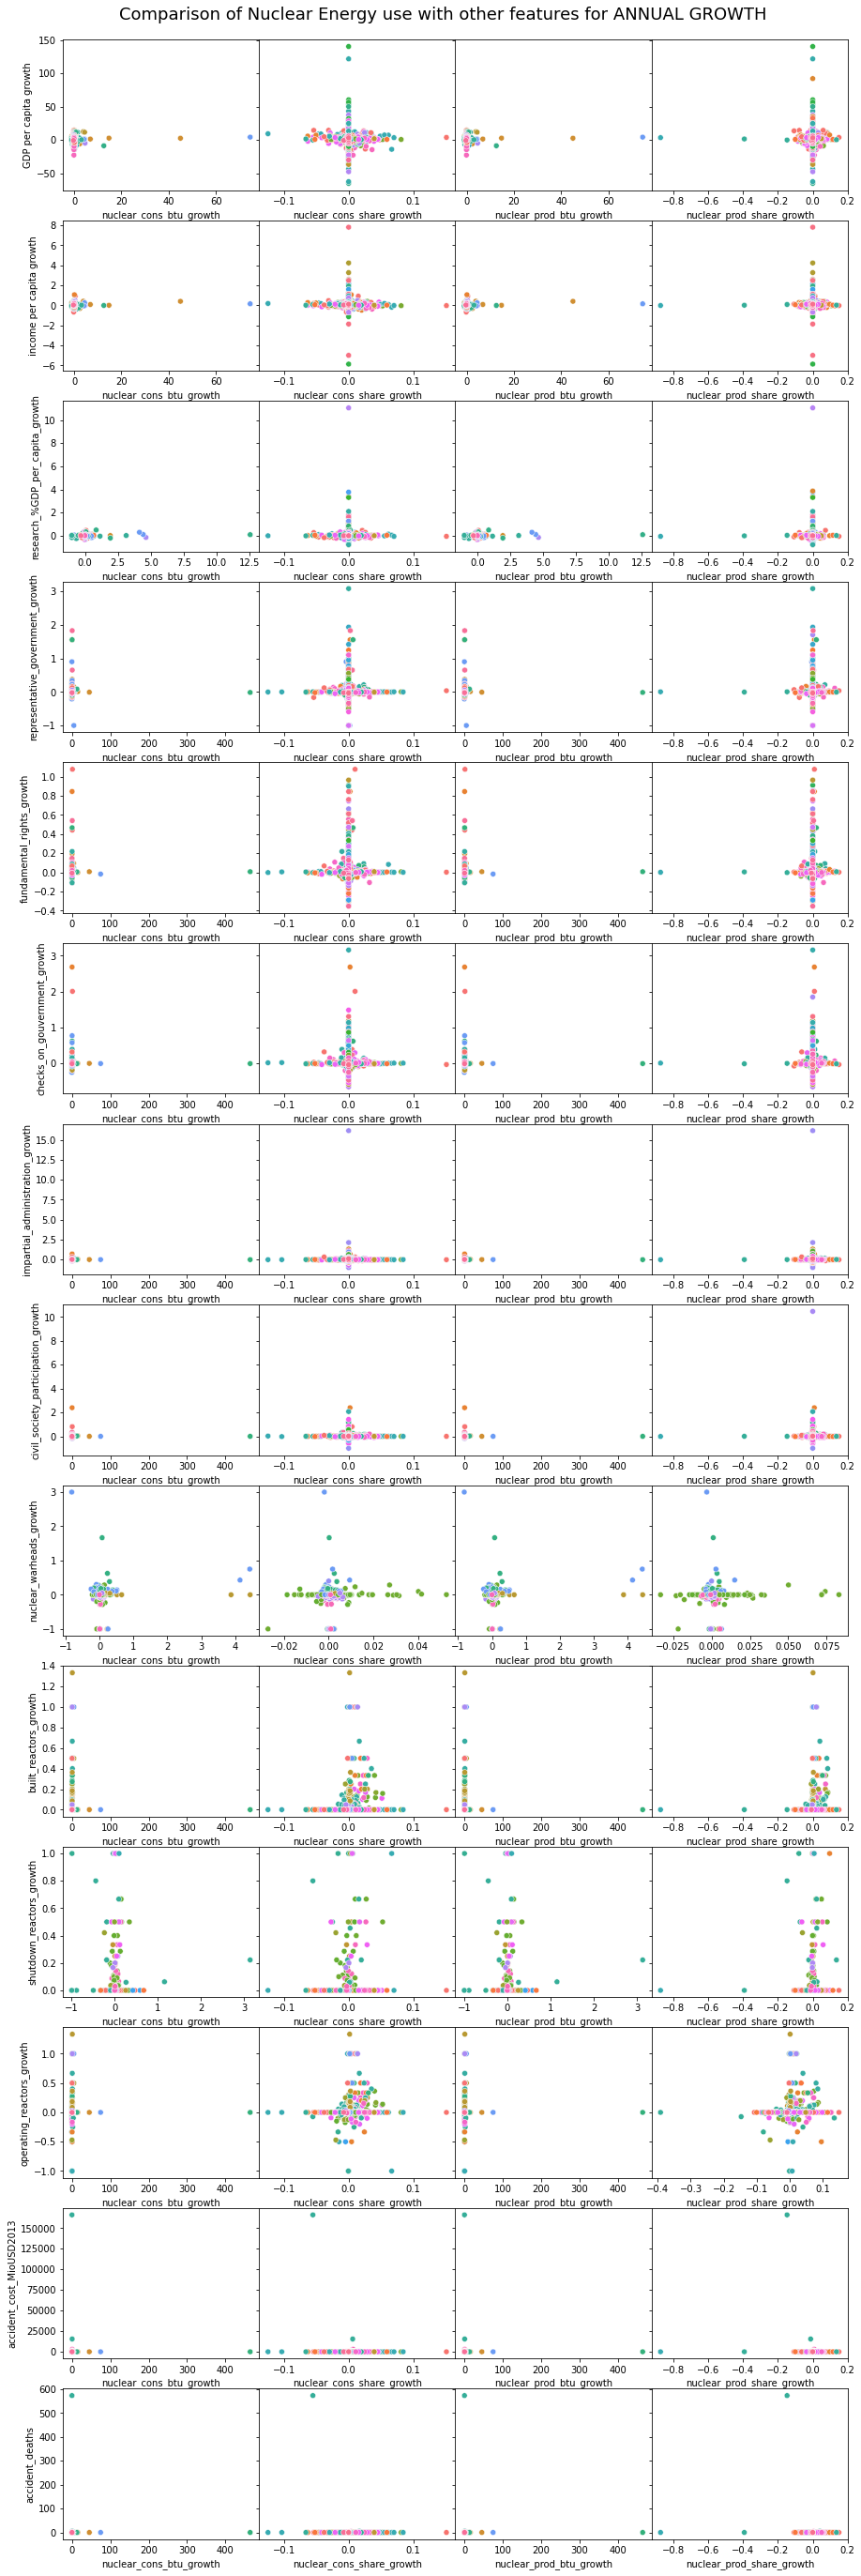

In [14]:
fig,ax = plt.subplots(len(data_growth.columns)-4,4, figsize=[15,3.5*(len(data_growth.columns)-4)], 
                      sharey='row', sharex=False, gridspec_kw=dict(wspace=0))
plt.suptitle('Comparison of Nuclear Energy use with other features for ANNUAL GROWTH', position=(0.5,0.89), fontsize=18)
for i,column in enumerate(data_growth.columns[:-4]):
    for j,column2 in enumerate(data_growth.columns[-4:]):
        sns.scatterplot(ax=ax[i,j],
            x=data_growth[column2], y=data_growth[column],
            hue=data_growth.index.get_level_values('country'), legend=None)#'full')
plt.show()

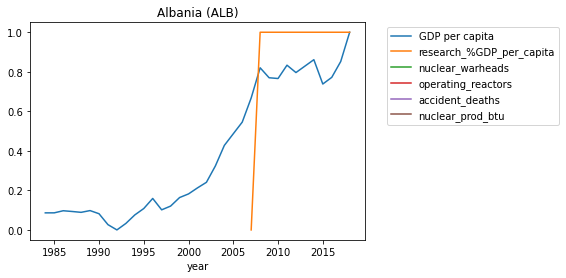

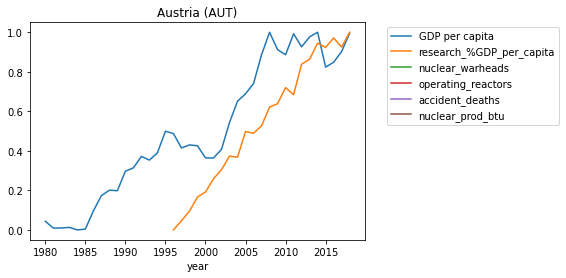

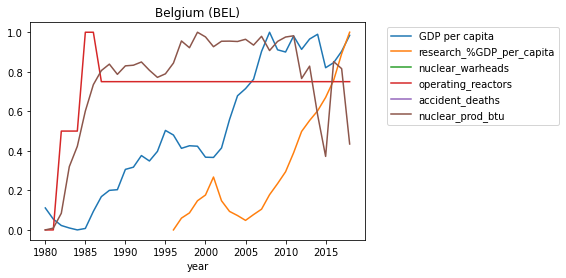

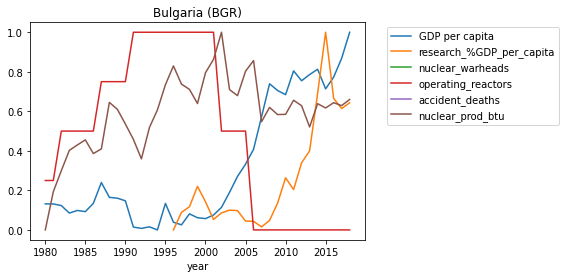

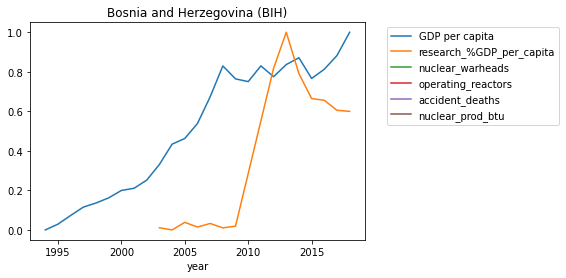

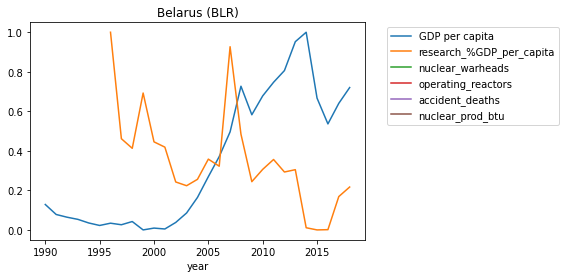

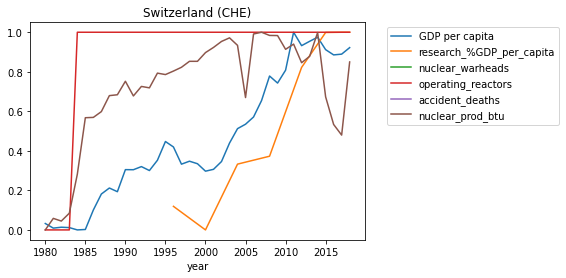

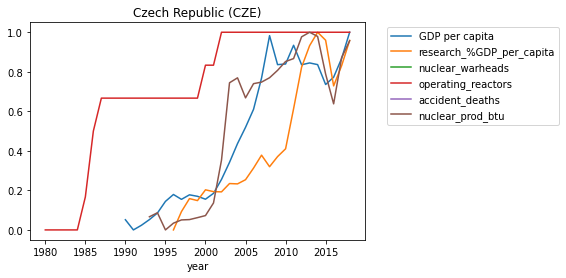

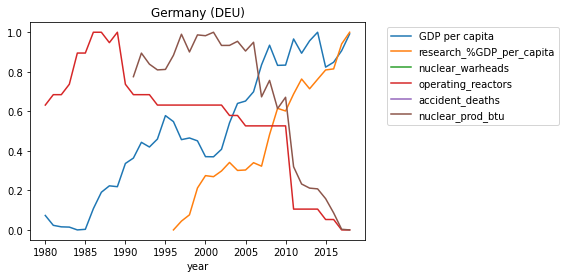

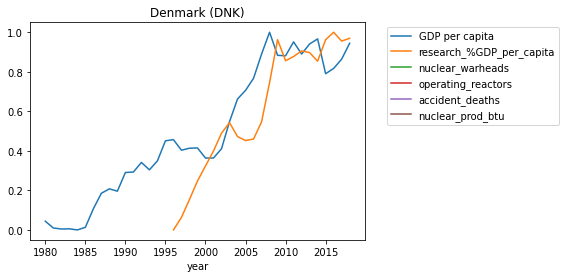

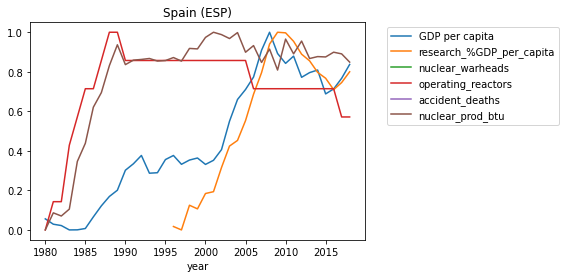

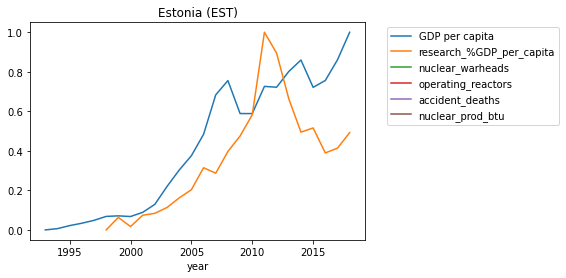

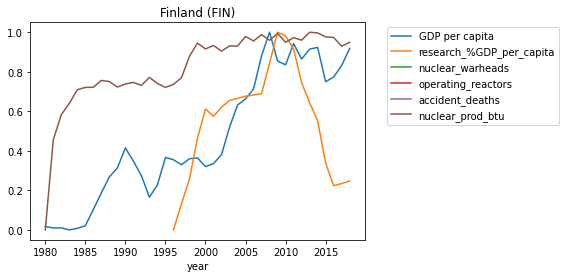

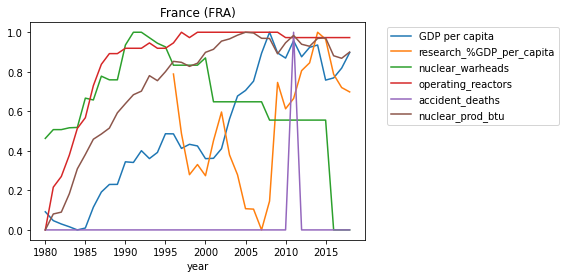

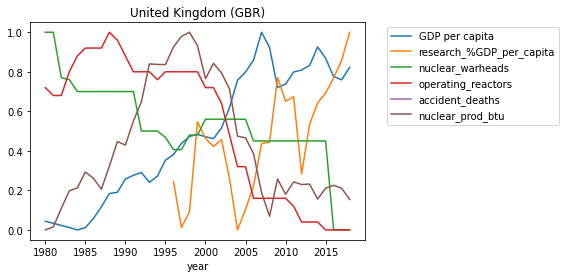

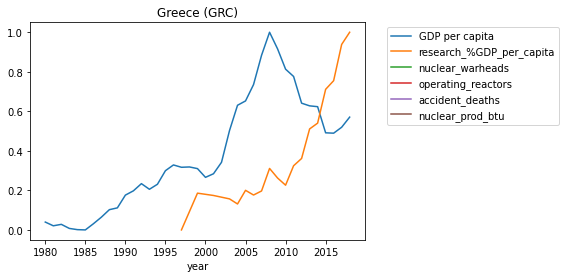

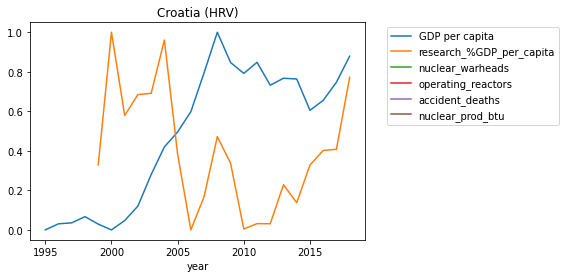

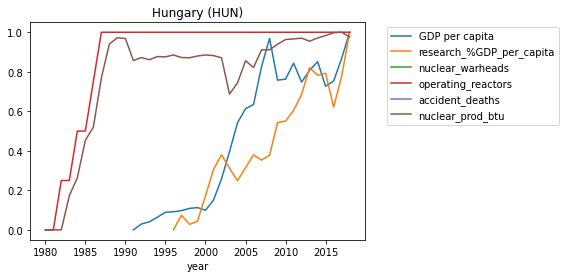

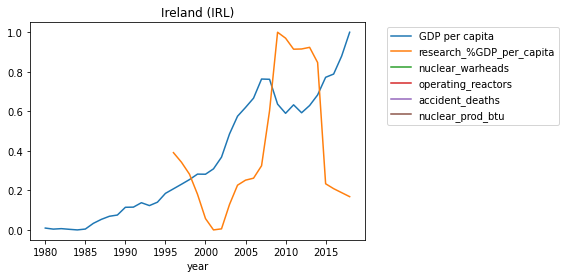

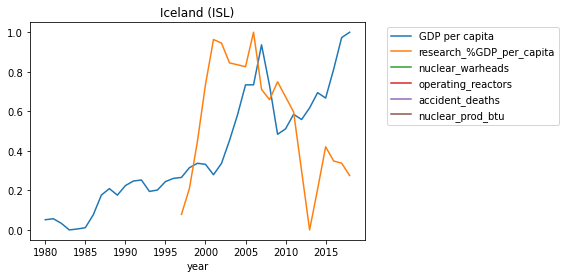

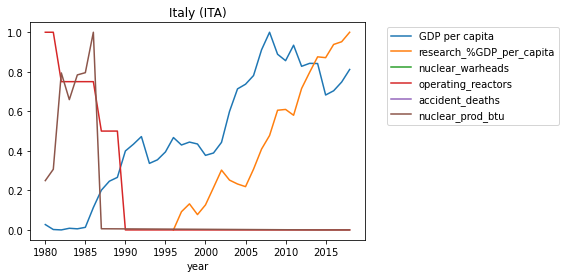

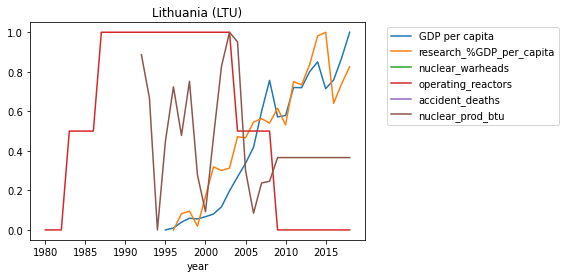

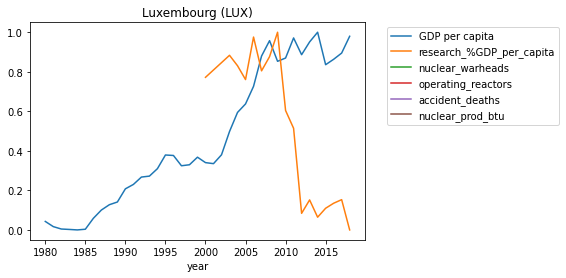

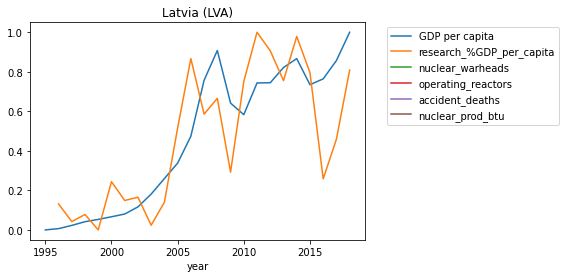

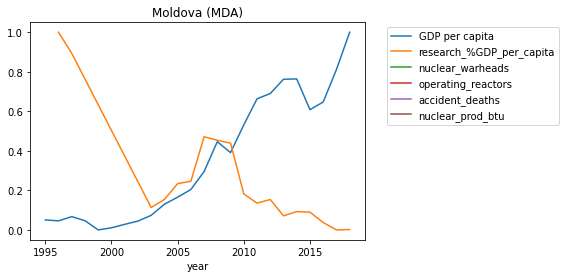

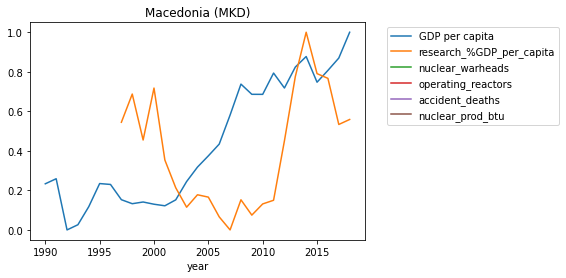

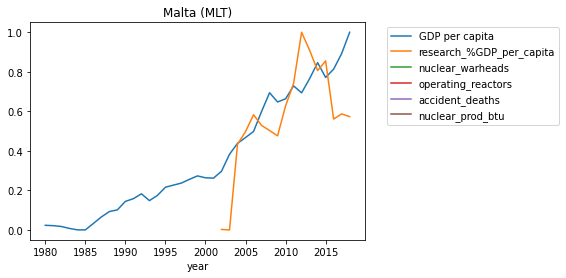

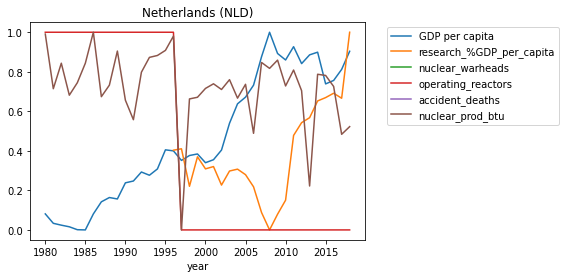

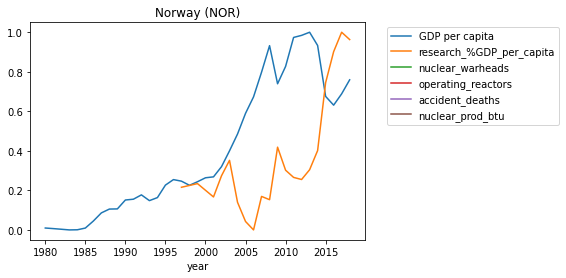

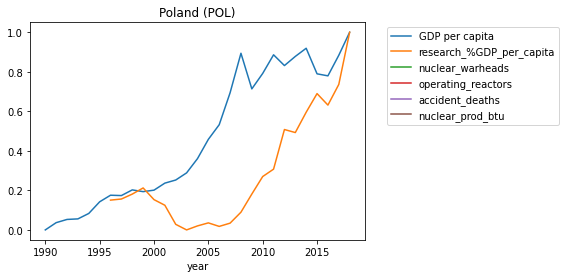

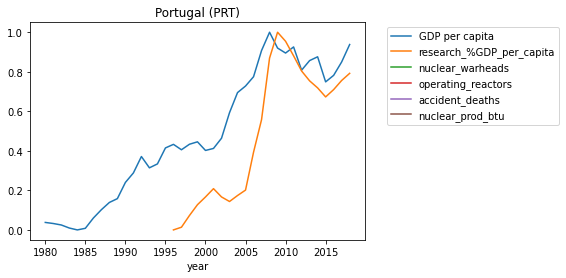

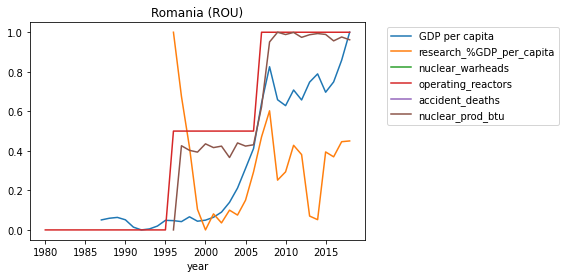

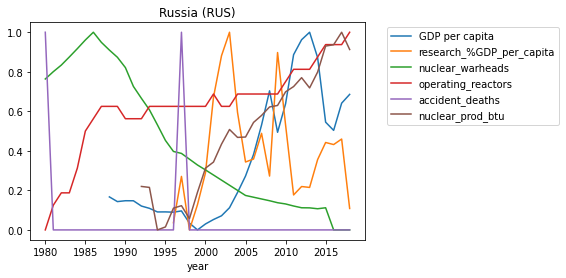

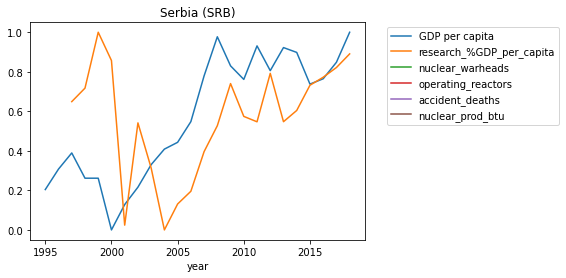

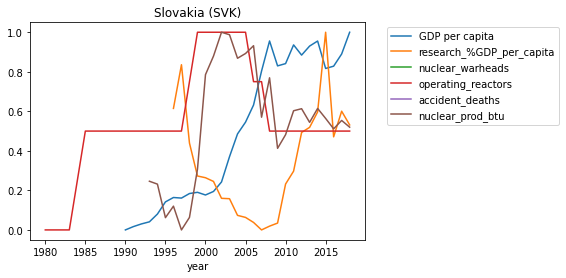

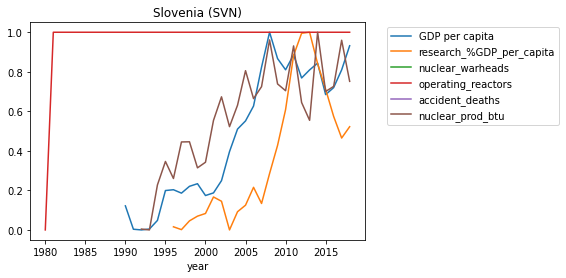

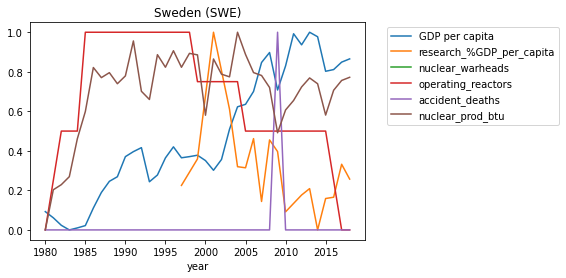

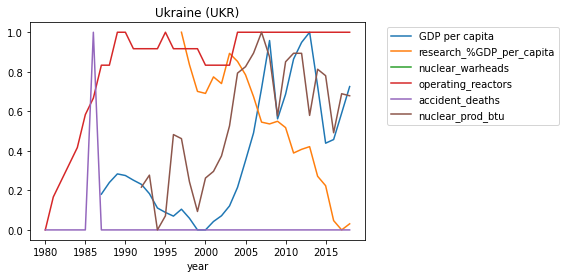

In [15]:
for i,country in enumerate(data_amount.index.get_level_values('country').drop_duplicates()):
    # PLOT ONLY OECD COUNTRIES
    #if country in cc.OECDas('ISO3')['ISO3'].to_list():
    # PLOT ONLY IF IN EUROPE
    if cc.continentas('ISO3').query("ISO3 == @country")['continent'].values=='Europe':
        columns = ['GDP per capita','research_%GDP_per_capita', 'nuclear_warheads','operating_reactors','accident_deaths','nuclear_prod_btu']
        df = data_amount.xs(country, level='country')[columns]
        normalized_df=(df-df.min())/(df.max()-df.min())
        normalized_df.plot()#legend=None)
        plt.title(cc.convert(country, src='ISO3', to='short') + ' (' + country + ')')
        #if i%5==0: 
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

### Comparing calulated GDP growth with data provided from source

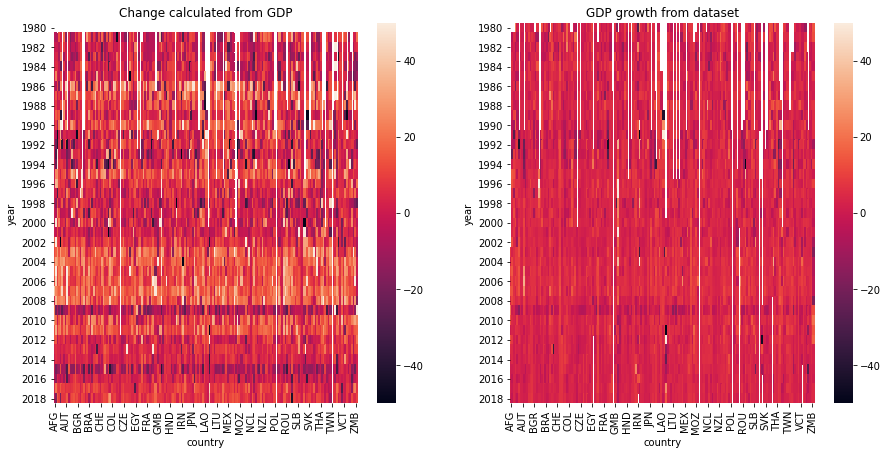

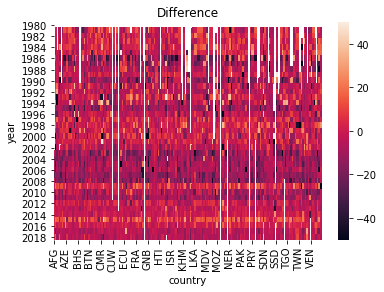

In [16]:
%matplotlib inline
plt.figure(figsize=[15,7])
plt.subplot(121)
sns.heatmap(data['GDP'].unstack().pct_change()*100, vmin=-50, vmax=50)
plt.title('Change calculated from GDP')
plt.subplot(122)
sns.heatmap(data['GDP growth'].unstack(), vmin=-50, vmax=50)
plt.title('GDP growth from dataset')
plt.show()

plt.figure()
sns.heatmap(
    data['GDP growth'].unstack().subtract(data['GDP'].unstack().pct_change()*100)
    , vmin=-50, vmax=50)
plt.title('Difference')
plt.show()

test = data['GDP growth'].unstack().subtract(data['GDP'].unstack().pct_change()*100)